<a href="https://colab.research.google.com/github/kittisaktaoma/colab_practice/blob/master/tmp/caox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#! pip install imbalanced-learn
#! pip install -U keras-tuner

In [45]:
from imblearn.over_sampling import SMOTE
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from kerastuner.tuners import BayesianOptimization
import matplotlib.pyplot as plt

In [3]:
#! git clone https://github.com/Superzchen/iFeature
! python iFeature/iFeature.py --file drive/My\ Drive/sample_test.fasta --type AAC --out AAC.txt

Descriptor type: AAC


In [ ]:
df = pd.read_csv("AAC.txt",sep="\t")
df2 = df.rename({'#': 'id'}, axis='columns')
df_02 = pd.DataFrame(df2.id.str.split('|',1).tolist(),columns = ['A','B'])
df_03 = pd.DataFrame(df_02.B.str.split('|',1).tolist(),columns = ['id','B'])
df_c = pd.concat([df_03.iloc[:,0], df.iloc[:,1:21]], axis=1)
df_c

In [ ]:
df = pd.read_csv("AAC.txt",sep="\t")
df2 = df.rename({'#': 'id'}, axis='columns')
df_02 = pd.DataFrame(df2.id.str.split('|',1).tolist(),columns = ['A','B'])
df_03 = pd.DataFrame(df_02.B.str.split('|',1).tolist(),columns = ['id','B'])
df_c = pd.concat([df_03.iloc[:,0], df.iloc[:,1:21]], axis=1)
df_c

In [ ]:
index_df = pd.read_csv("https://raw.githubusercontent.com/kittisaktaoma/colab_practice/master/tmp/sample.txt",sep="\t")
cdf = pd.merge(df_c,index_df,on='id')
cdf['cat'].value_counts()

In [15]:
# split into input (X) and output (Y) variables
X = cdf.iloc[:,1:21]
Y = cdf.iloc[:,21]
# split into 67% for train and 33% for test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=100)


In [20]:

def tune_nn_model(hp):
    model = keras.Sequential()
    
    drop_rate = hp.Choice('drop_rate',
                            [
                              0.0,
                              0.1,
                              0.2,
                              0.3,
                              0.4,
                              0.5,
                              0.6,
                              0.7,
                              0.8,
                              0.9
                            ])

     
    model.add(keras.layers.Dense(
      units=28,
      activation="relu",
      input_shape=[X_train.shape[1]]
    ))
    
    model.add(keras.layers.Dropout(rate=drop_rate))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dropout(rate=drop_rate))
    model.add(keras.layers.Dense(1, activation='sigmoid')) 
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    momentum = hp.Choice('momentum', [0.0, 0.2, 0.4, 0.6, 0.8, 0.9])

    model.compile(
        optimizer=keras.optimizers.SGD(lr, momentum=momentum),
        loss = 'binary_crossentropy',
        metrics = ['accuracy'])
    return model

In [34]:
b_tuner = BayesianOptimization(
    tune_nn_model,
    objective='accuracy',
    max_trials=20,
    executions_per_trial=5,
    directory='test_dir_19',
    project_name='b_tune_nn',
    seed=100
)

In [ ]:
b_tuner.search(x=X_train,
             y=y_train,
             epochs=1,
             validation_data=(X_test, y_test))

In [41]:
b_tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values


{'drop_rate': 0.0, 'learning_rate': 0.01, 'momentum': 0.9}

In [ ]:
best_model = b_tuner.get_best_models()[0]
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_split=0.2)

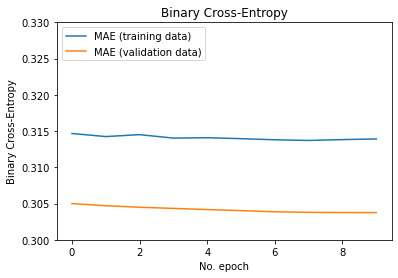

In [58]:
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('Binary Cross-Entropy')
plt.ylabel('Binary Cross-Entropy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.ylim([0.30,0.33]) 

plt.show()

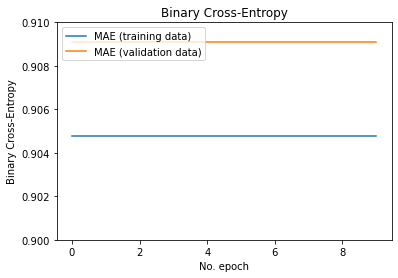

In [62]:
plt.plot(history.history['accuracy'], label='MAE (training data)')
plt.plot(history.history['val_accuracy'], label='MAE (validation data)')
plt.title('Binary Cross-Entropy')
plt.ylabel('Binary Cross-Entropy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.ylim([0.9,0.91]) 

plt.show()